# Hyperspectral image - Applied Machine Learning
### Sergio Morant Gálvez

**Índex**
1. [Introduction](#id1)
2. [Importing data](#id2)
3. [Unsupervised learning](#id3)
4. [Instance selection](#id4)
5. [Supervised Learning](#id5)
6. [Feature selection](#id6)
7. [Ensemble methods](#id7)
8. [Conclusions](#id8)<br>
[Extra: Silhouette coefficient plots](#id9)

## 1. Introduction<a name="id1"></a>

The aim of this project is to classify pixels of hyperspectral satellite images in which labels are available with its corresponding class.

One of the most important characteristics of satellite images usually is the great volume of data it has (increases quadratically with image dimensions and lineally with the number os channels or spectrums). Another is the reduced number of labelled instances available due to the high cost of it.
These are the reasons why, in this project, unsupervised learning is going to be used at first with all data (clustering) and after that classification is going to be carried out to classify the whole image using only a reduced subset of the data available (supervised learning).

In both cases the pixels will be considered to be separate instances, that is, the position of it in the image will not be taken into account.

## 2. Importing data<a name="id2"></a>

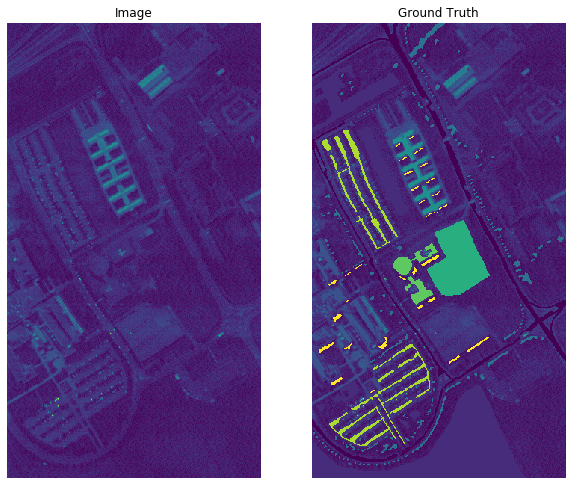

In [1]:
import numpy as np
import scipy.io.matlab as matlab
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.model_selection as model_selection
from sklearn.cluster import KMeans
from sklearn import metrics
#Necessary to see images in Jupyter Notebook:
%matplotlib inline  

# Reading the file from Matlab format .mat
mat_file =  "datasetB3.mat"
mat = matlab.loadmat(mat_file,squeeze_me=True) #returns a dictionary
list(mat.keys()) #variables saved


# Reading data
X = mat["X"]   #image (hypercube 3D: rows x columns x variables) 
Xl = mat["Xl"]   #labelled instances (instances x variables) 
Yl = mat["Yl"]   #class labels (instances x 1, 0=no class)   
del mat
Yl.shape
Yl_original = Yl.copy()


# Reshape of Ground truth as an image
Y = np.reshape(Yl, (X.shape[0], X.shape[1]),order="F")
Y.shape


#------------ Filter background: class 0 is removed ---------
#Class 0 is removed because it corresponds to pixels whose class is not known or different 
#from the 9 classes of interest
#These pixels will not be used for training nor for validation results

Nc=Yl.max()-Yl.min()+1
if Nc>2:
    Xl = Xl[Yl != 0,:];
    Yl = Yl[Yl != 0];  #Labels without 0's


#Ploting the pictures
fig = plt.figure()
fig.set_size_inches(10,10)
ax=plt.subplot(1,2,1)
ax.imshow(X[:,:,1]), ax.axis('off'), plt.title('Image')
ax=plt.subplot(1,2,2)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')

#This part is only to add the background
clasmap=Y; 
clasmap_masked = np.ma.masked_where(clasmap<1,clasmap)
plt.imshow(X[:,:,1])
plt.imshow(clasmap_masked)

## 3. Unsupervised learning<a name="id3"></a>

+ In this part the clustering algorithm **KMeans** has been used on the whole dataset to obtain a first grouping of the image pixels. The code has been developed so it can accept other images with different dimensions and/or number of variables.

In [2]:
#KMeans algorithm on the whole dataset specifying the number of clusters = 9
kmeans = KMeans(n_clusters  = 9, max_iter = 300, init = "k-means++")
Y_pred = kmeans.fit_predict(Xl)

+ Different metrics are studied to compare the results obtained with **KMeans** to the labels given (ground truth): 

Here the results of metrics such as *Adjusted Rand Score* and *Adjusted Mutual Information Score* are shown. These metrics measure the similarity between 2 partitions. <br>

*Adjusted Rand Score* does it by counting pairs and it's range goes from -1 to 1. <br>
*Adjusted Mutual Information Score* is based in the mutual information or conditional entropy concept and it's range goes from 0 to 1.<br>
In both cases a higher value means higher similarity

In [3]:
import warnings
warnings.filterwarnings('ignore') #Avoids FutureWarning for future versions

print("Adjusted Rand Score: ",round(metrics.adjusted_rand_score(Yl, Y_pred), 2)) #Range [-1,1]
print("Adjusted Mutual Info Score: ",round(metrics.adjusted_mutual_info_score(Yl, Y_pred), 2)) #Range [0,1]

Adjusted Rand Score:  0.31
Adjusted Mutual Info Score:  0.52


Silhouette coefficient is a useful method for interpreting and validating the consistency of the clusters in a dataset. It goes from -1 to 1 and higher values are associated with higher consistency. It's considered a way of measuring how "natural" is a specific partition.

Here below the average silhouette coefficients of both partitions are compared. At the end of the notebook are the plots of the silhouette coefficient: [Extra](#id9).

In [4]:
print("KMeans silhouette coefficient", round(metrics. silhouette_score(Xl, Y_pred, metric = "euclidean"),2))#Range [-1,1]
print("Ground truth silhouette coefficient", round(metrics. silhouette_score(Xl, Yl, metric = "euclidean"),2))

KMeans silhouette coefficient 0.44
Ground truth silhouette coefficient 0.07


The distribution from the labelled data shows a low silhouette coefficient, which means that it does not follow a natural partition of data. This is the reason why unsupervised learning is not going to produce a similar clustering of the image pixels.

In [5]:
print("Calinski-Harabasz coefficient KMeans", round(metrics.calinski_harabasz_score(Xl, Y_pred),2)) #Clustering KMeans
print("Calinski-Harabasz coefficient Ground truth",round(metrics.calinski_harabasz_score(Xl, Yl),2)) #Ground truth


Calinski-Harabasz coefficient KMeans 50558.37
Calinski-Harabasz coefficient Ground truth 13461.78


*Calinski-Harabsz* coefficient of both partitions confirmed the conclusions extracted from the silhouette coefficient results. KMeans partition has a higher C-H coefficient which means that's more related with a natural partition of data than the labels given.


(<matplotlib.image.AxesImage at 0x25a2e47e788>,
 (-0.5, 339.5, 609.5, -0.5),
 Text(0.5, 1.0, 'KMeans'))

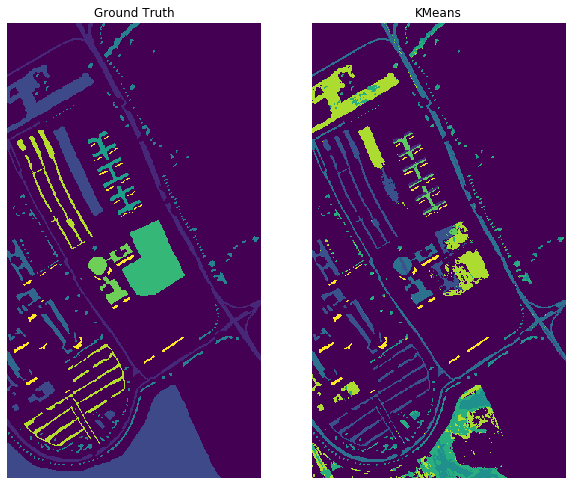

In [6]:
#---------------- Image drawing --------------
Yl_pred  = Yl_original.copy()
Yl_pred[Yl_pred != 0] = Y_pred  #IMPORTANT - Prediction is added to the data with 0's included to plot the image

Yl_pred = np.reshape(Yl_pred, (Y.shape[0], Y.shape[1]), order="F")

fig = plt.figure()
fig.set_size_inches(10,10)
ax=plt.subplot(1,2,1)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')
ax=plt.subplot(1,2,2)
ax.imshow(Yl_pred), ax.axis('off'), plt.title('KMeans')

#---------------Remove the comments in case of wanting to add a background--------
#clasmap=Yl_pred; 
#clasmap_masked = np.ma.masked_where(clasmap<1,clasmap)
#plt.imshow(X[:,:,1])
#plt.imshow(clasmap_masked)

In these pictures is easy to see how different are KMeans results from the classes given. <br>
It should be taken into account also that the classes obtained using KMeans don't have the same color code as the ground truth.

## 4. Instance selection<a name="id4"></a>

+ In this part we want to simulate the shortage of labelled data using only 5000 (aprox.) pixels to train a supervised learning classification algorithm. <br>
In order to achieve this **KMeans** has been used to obtain the centroid of each class and, based on the distance from the different instances to it (distance based on variables, not spatial distance), pick a set of representative instances keeping the original ratio. 

In [7]:
import pandas as pd
from itertools import chain

#Dictionaries are initialized to split the different classes
dictX = {}
dictY = {}
dictprop = {} #This dictionary keeps the ratio of each class

#Ratio calculation:
for i in range(1,10):
    dictX[i] = Xl[Yl == i,:];
    dictY[i] = Yl[Yl == i];
    dictprop[i] = len(dictX[i])/len(Xl)

#Initialization of variables to keep the aprox. 5000 observations that will be used afterwards in classification
X_class = []
Y_class = np.array([])
centers = [] #This list keeps the centroid of each class

for i in range(1,10):
    #KMeans algorithm is used to obtain the centroid of each class
    kmeans2 = KMeans(n_clusters = 1)
    kmeans2.fit(dictX[i])
    
    #Calculation of the distance of each point to the class centroid
    a = metrics.pairwise_distances(X = kmeans2.cluster_centers_[0].reshape(1,-1), Y = dictX[i])
    
    #A subset of observations is picked based on the distance to the centroid
    df1 = pd.DataFrame(dictX[i])
    df1["distance"] = a.reshape((len(dictX[i]),1))
    df1 = df1.sort_values("distance")
    df1 = df1.iloc[0:8*int(5000*dictprop[i]):8,0:-1] #Spaced selection
    
    
    X_class.append(np.asarray(df1))
    Y_class = np.append(Y_class, np.repeat(i,int(5000*dictprop[i])))

#X_class to array
X_class = np.array(list(chain(*X_class))) #X_class is the matrix with the 5000 observations that will be used in classification
Y_class = Y_class.reshape(-1,1) #Y_class is the matrix with the 5000 labels that will be used in classification

When it comes to picking the representative instances of each class, it has been decided to make a spaced selection to avoid the loss of variability that would mean picking only the points closest to the centroid (1st, 2nd, 3rd...) which would make it a lot harder for the algorithm to generalize classifying the whole image afterwards. <br>
This has been done by using a spaced selection once ordered based on their distance to the centroid (1st, 8th, 16th...).

***Of course one of the best strategies would have been to choose random points, but this was part of the problem boundaries.***

## 5. Supervised learning<a name="id5"></a>

+ In this section two different classification algorithms have been trained and tested on the reduced dataset to compare their performance on the whole image. **k-NN** (*k-Nearest Nighbors*) is the first of them.

*In both of them Cross Validation has been used to tune the main parameters.*

In [8]:
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler #For normalization
from sklearn.model_selection import GridSearchCV #For Cross Validation

#KNN requieres scaled variables:
X_class = StandardScaler().fit_transform(X_class)


#The reduced dataset is split in train and test (80% and 20% each)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_class, Y_class, test_size= 0.2, random_state = 11)

#-------------CROSS VALIDATION----------------
#Different weights, numbers of neighbors and leaf sizes are tried
weights= np.array(['uniform','distance'])
kneighbors = np.arange(1,20,1)
leaf_size = np.arange(10,30,5)
tuned_parameters = {'n_neighbors': kneighbors, 'weights': weights, 'leaf_size': leaf_size}

clf = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid=tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf.fit(X_train,y_train) #The combinations of models are trained
clf=clf.best_estimator_  #The one with better results is chosen
print("Chosen model:\n",clf,"\n")#Prints the parameters of the model chosen

print('OA train %0.2f' % clf.score(X_train, y_train)) 
preds_train = clf.predict(X_train)
print('Kappa train %0.2f' % metrics.cohen_kappa_score(y_train,preds_train))
#print(metrics.classification_report(y_train, preds_train)) #Detailed report with different metrics

print('OA test %0.2f' % clf.score(X_test, y_test))
preds_test = clf.predict(X_test)
print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test,preds_test))

CM=metrics.confusion_matrix(y_test,preds_test)
print("Confusion matrix of test data:\n",CM)


Chosen model:
 KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform') 

OA train 0.90
Kappa train 0.86
OA test 0.87
Kappa test 0.83
Confusion matrix of test data:
 [[145   0   8   0   0   0  10   4   0]
 [  0 418   0   2   0  14   0   0   0]
 [  2   0  35   0   0   0   0  18   0]
 [  0   4   0  62   0   0   0   0   0]
 [  0   0   0   0  27   0   0   0   0]
 [  0  53   0   0   0  61   0   0   0]
 [  5   0   1   0   0   0  22   1   0]
 [  0   0   4   0   0   0   0  87   0]
 [  0   0   0   0   0   0   0   0  17]]


Even though the results from the test substed should provide an estimate of the results we would find when classifying the whole image, it is possible that these results are too optimistic because the model has been trained only with approximately 7% of the total data and it's possible that the criterion chosen to pick the representative observations is not the optimum approach. 

If we had only chosen the closest points from the centroid, a good performance with the reduced dataset would still mean terrible results on the whole image.

In [11]:
#----------PREDICTION ON THE WHOLE IMAGE-------------
Xl_scaled = StandardScaler().fit_transform(Xl) #
knn_predict = clf.predict(Xl_scaled) #Prediction

CM_final=metrics.confusion_matrix(Yl,knn_predict)
print("Confusion matrix of the whole image: \n",CM_final)
#print(metrics.classification_report(Yl,svc_predict)) #Detailed report with different metrics
print('OA whole image %0.2f' % clf.score(Xl_scaled, Yl))
print('Kappa whole image %0.2f' % metrics.cohen_kappa_score(Yl,knn_predict))

Confusion matrix of the whole image: 
 [[ 5766    36   185     0    24    60   315   245     0]
 [    2 17373     0   763     0   507     0     4     0]
 [  206    13  1233     0     0     2     4   641     0]
 [    0   626     0  2414     5    18     0     0     1]
 [    4     0     0     0  1333     0     0     8     0]
 [   13  2293     6     1    34  2649     0    33     0]
 [  334     1    23     0     0     1   948    23     0]
 [  231    33   367     0     0    16     5  3030     0]
 [    3     0     0     0     0     0     0     0   944]]
OA whole image 0.83
Kappa whole image 0.78


The results on the complete image show that the score obtained previously from the test subset were a bit optimistic. However, taking into account what was said before, these results show that the model is capable of generalizing and providing relatively good classification results on observations that it has never seen before.

To compare the results obtained with **k-NN** the same procedure is followed with the **SVC** (*Support Vector Classifier*) algorithm: 

+ **SVC** has been chosen because the number of samples is not too big and methods based on kernel are not affected too much by a high number of features. Since they need to invert a matrix a much higher number of samples would increase too much the computational cost of these kind of algorithms.

In [12]:
from sklearn import svm

#SVM requires normalized features:
X_class = StandardScaler().fit_transform(X_class)

#The reduced dataset is split in train and test (80% and 20% each)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_class, Y_class, test_size= 0.2, random_state = 11)

#-------------CROSS VALIDATION----------------
#Different degrees and gammas are tried
degrees = np.arange(1,3,1)
gammas = np.logspace(-2, 0.5, 12)
tuned_parameters = {'degree': degrees,'gamma': gammas}

clf = GridSearchCV(svm.SVC(kernel='rbf'), tuned_parameters, cv=5,n_jobs=-1,verbose=0)

clf.fit(X_train,y_train) #The different combinations are trained
clf=clf.best_estimator_  #We keep the one that has better results
print("Chosen model:\n",clf,"\n")#Print the parameters of the chosen model

print('OA train %0.2f' % clf.score(X_train, y_train)) 
preds_train = clf.predict(X_train)
print('Kappa train %0.2f' % metrics.cohen_kappa_score(y_train,preds_train))
#print(metrics.classification_report(y_train, preds_train)) #Detailed report with different metrics

print('OA test %0.2f' % clf.score(X_test, y_test))
preds_test = clf.predict(X_test)
print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test,preds_test))

CM=metrics.confusion_matrix(y_test,preds_test)
print("Confusion matrix of test data:\n",CM)



Chosen model:
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.23101297000831592,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False) 

OA train 0.96
Kappa train 0.94
OA test 0.93
Kappa test 0.91
Confusion matrix of test data:
 [[154   0   4   0   0   0   5   4   0]
 [  0 426   0   2   0   6   0   0   0]
 [  1   0  38   0   0   0   0  16   0]
 [  0   2   0  64   0   0   0   0   0]
 [  0   0   0   0  26   1   0   0   0]
 [  0  19   0   0   0  95   0   0   0]
 [  3   0   1   0   0   0  25   0   0]
 [  0   0   4   0   0   0   0  87   0]
 [  0   0   0   0   0   0   0   0  17]]


Classification on both train and test subsets using **SVC** provides very positive results and better than the ones from **k-NN**. It does not seem to be overfitting since the numbers from both test and train are quite similar.


In [13]:
#----------PREDICTION ON THE WHOLE IMAGE-------------
Xl_scaled = StandardScaler().fit_transform(Xl)
svc_predict = clf.predict(Xl_scaled) #Prediction

CM_final=metrics.confusion_matrix(Yl,svc_predict)
print("Confusion matrix of the whole image:\n",CM_final)
#print(metrics.classification_report(Yl,svc_predict)) #Detailed report with different metrics
print('OA whole image %0.2f' % clf.score(Xl_scaled, Yl))
print('Kappa whole image %0.2f' % metrics.cohen_kappa_score(Yl,svc_predict))


Confusion matrix of the whole image:
 [[ 6048    30    59     0     1   159   133   201     0]
 [    0 17547     0   807     0   292     0     3     0]
 [  201    11  1320     0     0    16     0   551     0]
 [    0   381     0  2604     0    79     0     0     0]
 [    0     1     0     0  1312    32     0     0     0]
 [   10  1039     1     0     0  3968     0    11     0]
 [  371     0     3     0     0     5   941    10     0]
 [  239    24   176     0     0    40     2  3201     0]
 [    0     0     0     0     0    66     0     0   881]]
OA whole image 0.88
Kappa whole image 0.85


Same as with **k-NN**, results on the test subset are proven to be somewhat optimistic. However, the results using **SVC** on the whole image are not that far away from them and are quite good (and better than the ones from **k-NN**).

(<matplotlib.image.AxesImage at 0x25a33c820c8>,
 (-0.5, 339.5, 609.5, -0.5),
 Text(0.5, 1.0, 'SVC'))

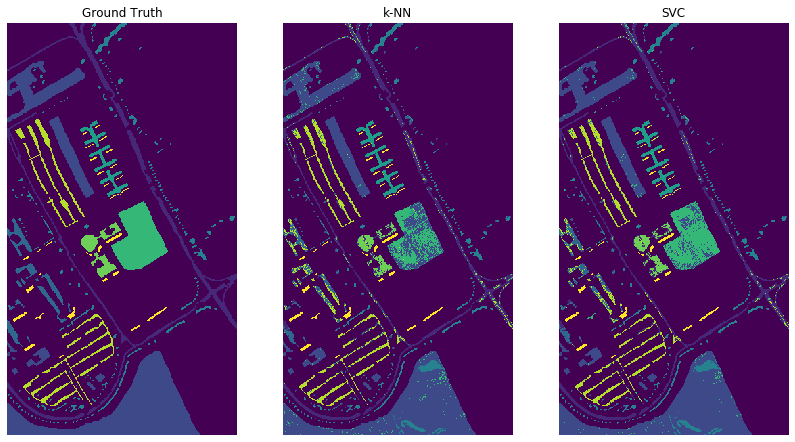

In [14]:
#Images
imagen_predicha = Yl_original.copy()
imagen_predicha[imagen_predicha != 0] = svc_predict

imagen_predicha = np.reshape(imagen_predicha, (Y.shape[0], Y.shape[1]), order="F")

imagen_knn = Yl_original.copy()
imagen_knn[imagen_knn != 0] = knn_predict 

imagen_knn = np.reshape(imagen_knn, (Y.shape[0], Y.shape[1]), order="F")

fig = plt.figure()
fig.set_size_inches(14,14)

ax=plt.subplot(1,3,1)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')
ax=plt.subplot(1,3,2)
ax.imshow(imagen_knn), ax.axis('off'), plt.title('k-NN')
ax=plt.subplot(1,3,3)
ax.imshow(imagen_predicha), ax.axis('off'), plt.title('SVC')

#---------------Remove the comments in case of wanting to add background--------
#clasmap=imagen_predicha; #aqui deberiamos poner nuestra clasificacion
#clasmap_masked = np.ma.masked_where(clasmap<1,clasmap)
#plt.imshow(X[:,:,1])
#plt.imshow(clasmap_masked)

Comparing the pictures above it's possible to see the differences between the 2 algorithms used. <br>
The classification obtained from using **SVC** model is closer to the ground truth than the one obtained from using **k-NN**.

## 6. Feature selection<a name="id6"></a>

+ In this section we're going to select the most useful features, that is, the bands of the spectrum, to classify the samples. Doing so we'll get rid of those bands that are difficulting or not improving the results of the classification algorithms. <br>
This will result in a simplification of the model, and hence a computational cost and time reduction.

Feature selection has been carried out using **Random Forest** algorithm, which allows us to know which are the most useful variables based on impurity. Impurity can be calculated using *gini* coefficient or entropy.

In general, the variables used in the first branches of the trees, are those which give more information and thus, the ones we'll keep for the reduced model.

In [15]:
#-----------------------------FEATURE SELECTION - RANDOM FOREST---------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(RandomForestClassifier(n_estimators = 300))
sel.fit(X_train, y_train)

#sel.get_support() #Returns a boolean array where the most useful variables contain "True"

#Here the variables with "True" in get_support are selected 
X_train_feat= X_train[:, np.where(sel.get_support() == True)[0]].copy() 
X_test_feat= X_test[:, np.where(sel.get_support() == True)[0]].copy()

print("Initial number of variables: ", np.shape(Xl)[1])
print("Number of variables after feature selection: ", np.sum(sel.get_support()))

Initial number of variables:  102
Number of variables after feature selection:  41


In [16]:
#Once the features have been selected we train again the SVC model

clf.fit(X_train_feat, y_train) #Model training with features selected

print('OA train %0.2f' % clf.score(X_train_feat, y_train)) 
preds_train = clf.predict(X_train_feat)
print('Kappa train %0.2f' % metrics.cohen_kappa_score(y_train,preds_train))

print('OA test %0.2f' % clf.score(X_test_feat, y_test))
preds_test = clf.predict(X_test_feat)
print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test,preds_test))

#Classification of the whole image (FEATURE SELECTED)
Xl_scaled_feat = Xl_scaled[:, np.where(sel.get_support() == True)[0]].copy()

svc_predict_feat = clf.predict(Xl_scaled_feat)

print('OA whole image %0.2f' % clf.score(Xl_scaled_feat, Yl))
print('Kappa whole image %0.2f' % metrics.cohen_kappa_score(Yl,svc_predict_feat))

OA train 0.92
Kappa train 0.89
OA test 0.91
Kappa test 0.88
OA whole image 0.87
Kappa whole image 0.83


The results obtained after feature selection are very similar to the ones we had before it. Taking into account that the model is now using less than a half of the initial variables, these results are quite positive. We get to keep the effectiveness of the model and increase its efficiency reducing the algorithm's computational cost.

Here below it's possible to compare the results over the image

(<matplotlib.image.AxesImage at 0x25a34cd8848>,
 (-0.5, 339.5, 609.5, -0.5),
 Text(0.5, 1.0, 'SVC after Feature Selection'))

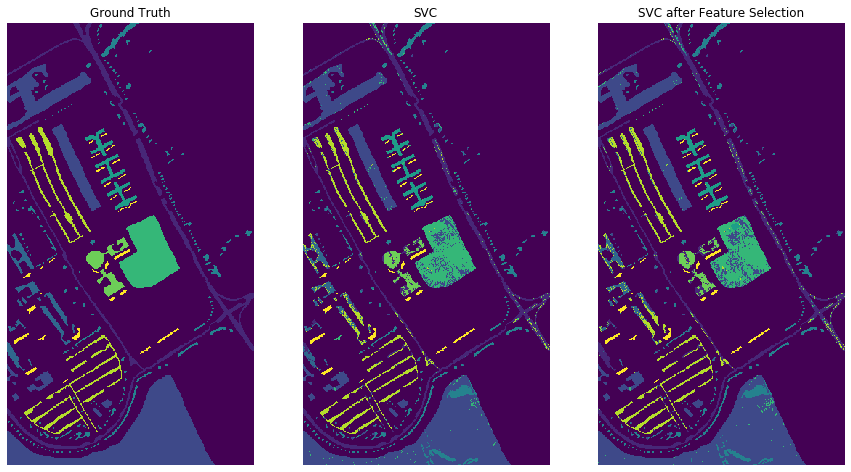

In [17]:
imagen_predicha_feat = Yl_original.copy()
imagen_predicha_feat[imagen_predicha_feat != 0] = svc_predict_feat  

imagen_predicha_feat = np.reshape(imagen_predicha_feat, (Y.shape[0], Y.shape[1]), order="F")

fig = plt.figure()
fig.set_size_inches(15,15)
ax=plt.subplot(1,3,1)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')
ax=plt.subplot(1,3,2)
ax.imshow(imagen_predicha), ax.axis('off'), plt.title('SVC')
ax=plt.subplot(1,3,3)
ax.imshow(imagen_predicha_feat), ax.axis('off'), plt.title('SVC after Feature Selection')

## 7. Métodos ensemble<a name="id7"></a>

+ Finally, we'll also use ensemble methods to classify the samples of the whole image training only with the subset of approximately 5000 cases and features selected.

The first ensemble method to be used is **Random Forest**:

In [18]:
n_stimators = np.arange(300, 501, 100)
tuned_parameters = {'n_estimators': n_stimators}

clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf.fit(X_train_feat, y_train)
clf=clf.best_estimator_  #Keeps the best model
print("Chosen model:\n",clf)

y_pred1 = clf.predict(X_train_feat)
y_pred2 = clf.predict(X_test_feat)
y_pred3 = clf.predict(Xl_scaled_feat)

#print(metrics.classification_report(y_test,y_pred)) #Detailed report with different metrics

print('OA train %0.2f' % clf.score(X_train_feat, y_train))
print('Kappa train %0.2f' % metrics.cohen_kappa_score(y_train,y_pred1))
print('OA test %0.2f' % clf.score(X_test_feat, y_test))
print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test,y_pred2))
print('OA whole image %0.2f' %clf.score(Xl_scaled_feat, Yl))
print('Kappa whole image %0.2f' % metrics.cohen_kappa_score(Yl,y_pred3))


Chosen model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
OA train 1.00
Kappa train 1.00
OA test 0.91
Kappa test 0.88
OA whole image 0.87
Kappa whole image 0.82


There isn't a really big difference between the results obtained using **Random Forest** and the ones we had obtained using **SVC**. 

Last but not least, we'll use **Gradient Boosting**

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

n_stimators = np.arange(400, 601, 100)
tuned_parameters = {'n_estimators': n_stimators}

abc = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
abc.fit(X_train_feat, y_train)
abc=abc.best_estimator_  #Keeps the best model
print("Modelo seleccionado:\n",abc)

y_pred1 = abc.predict(X_train_feat)
y_pred2 = abc.predict(X_test_feat)
y_pred3 = abc.predict(Xl_scaled_feat)

#print(metrics.classification_report(y_test,y_pred)) #Detailed report with different metrics

print('OA train %0.2f' % abc.score(X_train_feat, y_train))
print('Kappa train %0.2f' % metrics.cohen_kappa_score(y_train,y_pred1))
print('OA test %0.2f' % abc.score(X_test_feat, y_test))
print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test,y_pred2))
print('OA whole image %0.2f' %abc.score(Xl_scaled_feat, Yl))
print('Kappa whole image %0.2f' % metrics.cohen_kappa_score(Yl,y_pred3))

imagen_predicha_rand_forest = Yl_original.copy()
imagen_predicha_rand_forest[imagen_predicha_rand_forest != 0] = y_pred3  

imagen_predicha_rand_forest = np.reshape(imagen_predicha_rand_forest, (Y.shape[0], Y.shape[1]), order="F")

Modelo seleccionado:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
OA train 1.00
Kappa train 1.00
OA test 0.93
Kappa test 0.90
OA whole image 0.88
Kappa whole image 0.84


Again, **Gradient Boosting** results are quite close to the rest. There's no algorithm that clearly beats the rest with these problem's boundaries.

(<matplotlib.image.AxesImage at 0x25a37938d08>,
 (-0.5, 339.5, 609.5, -0.5),
 Text(0.5, 1.0, 'Gradient Boosting after FS'))

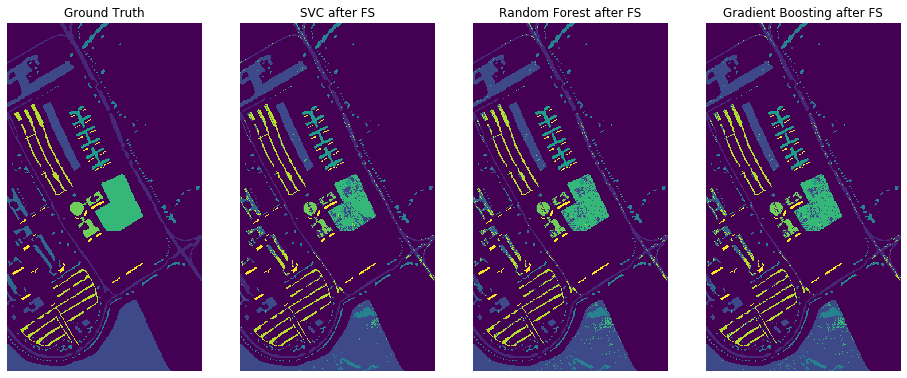

In [20]:
imagen_gb = Yl_original.copy()
imagen_gb[imagen_gb != 0] = y_pred3 

imagen_gb = np.reshape(imagen_gb, (Y.shape[0], Y.shape[1]), order="F")

fig = plt.figure()
fig.set_size_inches(16,16)
ax=plt.subplot(1,4,1)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')
ax=plt.subplot(1,4,2)
ax.imshow(imagen_predicha_feat), ax.axis('off'), plt.title('SVC after FS')
ax=plt.subplot(1,4,3)
ax.imshow(imagen_predicha_rand_forest), ax.axis('off'), plt.title('Random Forest after FS')
ax=plt.subplot(1,4,4)
ax.imshow(imagen_gb), ax.axis('off'), plt.title('Gradient Boosting after FS')

## 8. Conclusions<a name="id8"></a>

In this project it has been possible to study the clustering and classifications of a hyperspectral image with given labelled data.

First, a clustering algorithm has been used (unsupervised learning) to obtain a partition of the image data and it has been compared to the one from the labelled data given. Their difference has been checked and it's been proved that the partition obtained through using **KMeans** is closer to a natural partition than the one from the labelled data thanks to the silhouette coefficient.

After that, shortage of labelled data has been simulated by picking approximately 5000 representative samples from the dataset. Two different algorithms have been used and compared to classify the whole image training only with a training subset from the 5000 samples. Both **k-NN** and **SVC** supervised learning classifier algorithms have been tested being **SVC** the one with better results (88% overall accuracy over the whole image).

This has showed how these models, specially **SVC**, are able to generalize when trained with a good representative sample of the dataset even if it contains only about 7% of the total number of samples.
This also shows that the criterion used to pick the 5000 samples, using a spaced selection based on the distance from the samples to their class' centroid is effective and useful. 

Later, feature selection has been carried out using **Random Forest** algorithm reducing the number of bands (features) used in more than half and thus increasing the model efficiency without compromising the model effectiveness. 

Finally, with both instances and features selected, two ensemble methods have been used to perform classification obtaining results similar to the ones from **SVC**. These two ensemblw methods are **Random Forest** and **Gradient Boosting**.

None of the different algorithms used has outperformed importantly the rest, and the summary of the socres obtained can be found below:


|                  Algorithm 	| Overall Accuracy 	|  Kappa Coefficient        	|
|---------------------------:	|------------------	|---------------------------	|
|                       k-NN 	| 0.83             	| 0.78       	                |
|                        SVC 	| 0.88             	| 0.85       	                |
|               SVC after FS    | 0.87             	| 0.83       	                |
|     Random Forest after FS 	| 0.87             	| 0.82       	                |
| Gradient Boosting after FS 	| 0.88             	| 0.84       	                |

## Extra: Silhouette coefficient plot <a name="id9"></a>

Here below the silhouette coefficient plots are shown in both the partition obtained using **KMeans** and the one from the labelled data given.

For n_clusters = 9 The average silhouette_score is : 0.0712


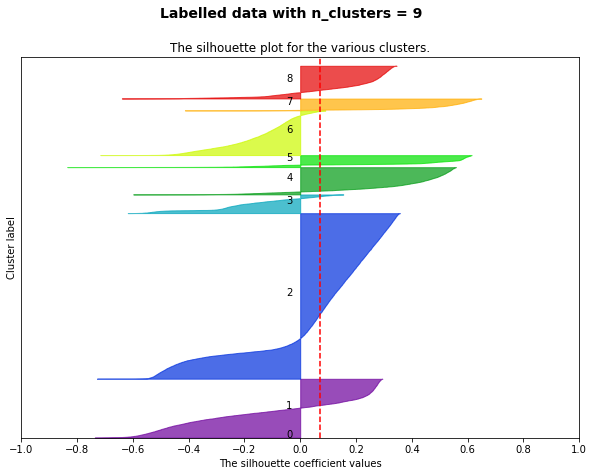

In [22]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [9]

for n_clusters in range_n_clusters:

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The plot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Xl) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    cluster_labels = Yl

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Xl, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,4))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Xl, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2 , 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Labelled data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

For n_clusters = 9 The average silhouette_score is : 0.4439


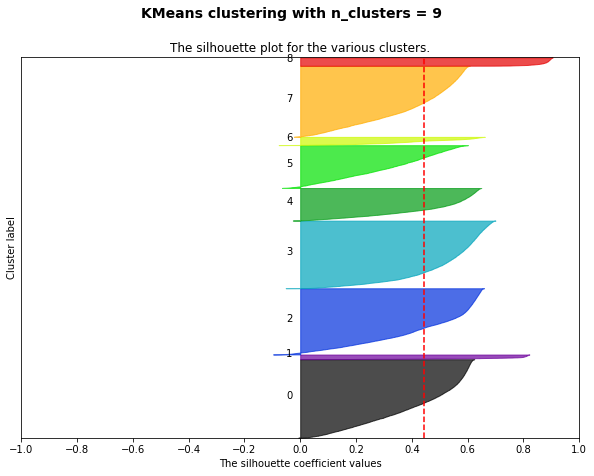

In [23]:
range_n_clusters = [9]

for n_clusters in range_n_clusters:

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The plot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Xl) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    cluster_labels = Y_pred

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Xl, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,4))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Xl, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2 , 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("KMeans clustering "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

As commented in point [number 3](#id3), the partition obtained through **KMeans** is closer to a natural partition since there are a lot fewer points with a negative silhouette coefficient. A negative silhouette coefficient means that point is further away from it's cluster centroid than from the next cluster's centroid.